In [1]:
### imports
import cv2
import numpy as np

In [2]:
### constants
bg_size = 249
face_size = 184
bg_size_test = 564
face_size_test = 232
dimension = 20 * 15
pixels = dimension * 3
# pixels = dimension # GRAY

In [3]:
### initialization
bg = np.zeros((bg_size, pixels))
face = np.zeros((face_size, pixels))
mu_bg = np.zeros(pixels)
mu_face = np.zeros(pixels)
sigma_bg = np.zeros((pixels, pixels))
sigma_face = np.zeros((pixels, pixels))

In [4]:
### define vectorization and conversions
# vectorize image in column-major order
def vectorize(data, bg_face, i):
    path = "%sData/%s/%03d.jpg" %(data, bg_face, i+1)
    img = cv2.imread(path)

    ### use other color space
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2XYZ)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return np.reshape(np.reshape(img, (dimension, 3), 'F'), pixels, 'F')
    # return np.reshape(img, pixels, 'F') # GRAY

In [5]:
### fill matrices with all images and find mu

# background
for i in range(bg_size):
    vec = vectorize("training", "background", i)
    bg[i] = vec # insert image to background matrix
    mu_bg += vec # add to mu vector
mu_bg = np.true_divide(mu_bg, bg_size) # divide mu vector by number of images


# face
for i in range(face_size):
    vec = vectorize("training", "face", i)
    face[i] = vec # insert image to face matrix
    mu_face += vec # add to mu vector
mu_face = np.true_divide(mu_face, face_size) # divide mu vector by number of images

In [6]:
### find covariance

# background
for i in range(bg_size):
    var = bg[i] - mu_bg
    sigma_bg += (var * var.T) # apply covariance formula
sigma_bg = np.diag(np.true_divide(sigma_bg, bg_size)) # convert to diagonal matrix

# face
for i in range(face_size):
    var = face[i] - mu_face
    sigma_face += (var * var.T) # apply covariance formula
sigma_face = np.diag(np.true_divide(sigma_face, face_size)) # convert to diagonal matrix

In [7]:
### calculate accuracy
det_bg = 0
det_face = 0

# first part of the expression that only needs to be computed once
for i in range(pixels):
    det_bg += np.log(sigma_bg[i])
    det_face += np.log(sigma_face[i])
det_bg *= (-0.5)
det_face *= (-0.5)

# get the probability with Norm_x(mu, sigma)
def norm(det, x, mu, sigma):
    var = 0
    for i in range(pixels):
        var += (x[i]-mu[i])**2 / (2*sigma[i])
    return det - var

# count the number of true positives and the accuracy
bg_acc = 0
for i in range(bg_size_test):
    vec = vectorize("testing", "background", i)
    bg_acc += (norm(det_bg, vec, mu_bg, sigma_bg) > norm(det_face, vec, mu_face, sigma_face))
print("Background: %d/564 = %.10f" %(bg_acc, bg_acc / bg_size_test))

face_acc = 0
for i in range(face_size_test):
    vec = vectorize("testing", "face", i)
    face_acc += (norm(det_face, vec, mu_face, sigma_face) > norm(det_bg, vec, mu_bg, sigma_bg))
print("      Face: %d/232 = %.10f" %(face_acc, face_acc / face_size_test))

Background: 421/564 = 0.7464539007
      Face: 191/232 = 0.8232758621


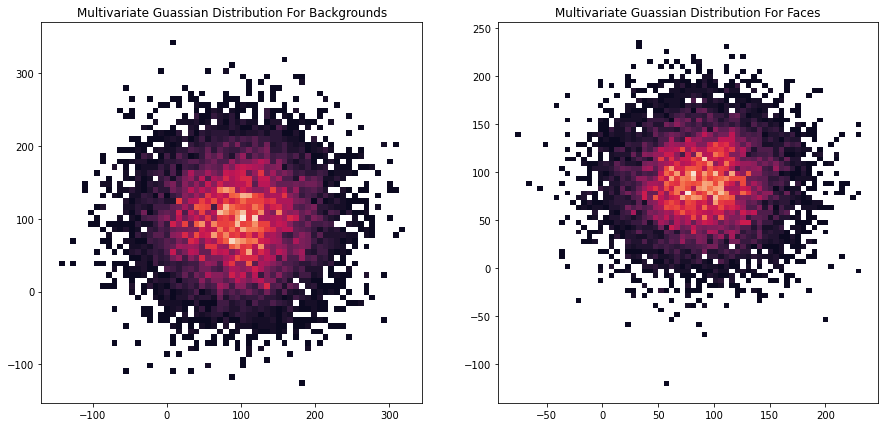

In [8]:
### visualization
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

plt.figure(figsize=(15, 7))

# background
bg_norm = multivariate_normal(mu_bg, sigma_bg) # model the distribution
bg_plot = bg_norm.rvs(size = 10000) # size of random sample
plt.subplot(1, 2, 1)
sns.histplot(x=bg_plot[:,0], y=bg_plot[:,1], cmap="rocket")
#sns.kdeplot(x=data[:,0], y=data[:,1], levels=1, color="white", linewidths=2)
plt.title("Multivariate Guassian Distribution For Backgrounds")

# face
face_norm = multivariate_normal(mu_face, sigma_face) # model the distribution
face_plot = face_norm.rvs(size = 10000) # size of random sample
plt.subplot(1, 2, 2)
sns.histplot(x=face_plot[:,0], y=face_plot[:,1], cmap="rocket")
#sns.kdeplot(x=data[:,0], y=data[:,1], levels=1, color="white", linewidths=2)
plt.title("Multivariate Guassian Distribution For Faces")

plt.show()